# Transfer Learning

### Aufgabe
_Wählen Sie nun 5 andere Hunderassen aus. Nutzen Sie Transfer Learning zur Klassifikation dieser
Rassen, d.h. laden Sie die Gewichte aus Ihrem in Teilaufgabe B5 trainierten Modell als initiale
Gewichte für das neue Training. Beschreiben Sie ihr Vorgehen im Kurzreport und setzen Sie die
Evaluation dieses erneuten Trainings in Relation zu den Evaluationsergebnissen ihres ursprünglichen
Modells._


---

> Aufbau ähnlich zu `deep_learning.ipynb`   
> Doppelte Schritte werden nicht erklärt und sind in dem Deep Learning Notebook genauer erläutert

Für das Training wurden gezielt Hunderassen ausgewählt, die sich in ihren Merkmalen, wie Farbe, Größe, Felltyp und anderen Eigenschaften, deutlich von den Hunden aus dem deep-learning Teil unterscheiden. Da die Klassifiezierungsebenen des Basis Models verworfen werden, kann durch die Wahl anderer Hunde die Merkmalsextraktion getestet werden.


![Afghan Dog](./docs/transfer_learning/bernese.jpg) ![Afghan Dog](./docs/transfer_learning/chichi.jpg) ![Afghan Dog](./docs/transfer_learning/elkhound.jpg) ![Afghan Dog](./docs/transfer_learning/keeshond.jpg) ![Afghan Dog](./docs/transfer_learning/pomeranian.jpg)

In [8]:
import keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%matplotlib inline

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from utils.utils import setup_dataset, generateDatasetArrays, getDognames
from helper.visualize import visualize_history, visualize_predictions

# load configuration
import config as Config

# config overrides
Config.DOG_LABEL_IDS = [0, 23, 107, 109, 88] # 5 andere Hunderassen

In [9]:
train_dataset, test_dataset, label_lookup_table, info = setup_dataset('../dataset', labels=Config.DOG_LABEL_IDS)

def preprocess(data):
    data["original_image"] = tf.identity(data["image"])
    data["image"] = tf.image.resize(data["image"], Config.RESIZE_SIZE)
    data["label"] = label_lookup_table.lookup(data["label"])
    return data

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .prefetch(tf.data.AUTOTUNE)
)

2024-12-18 14:45:48.906386: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total Image count:  500
Train Dataset Size: 375
Test Dataset Size: 125


---

Das trainierte Modell aus dem Deep Learning Teil wurde abgespeichert. Dieses wird nun wieder geladen und die letzten 3 Schichten werden entfernt (da die Schichten davor nur für die Feature Extraction sind).
Danach werden drei neue Schichten im selben Format wie die entfernten hinzugefügt. Diese Schichten werden mit den neuen Daten trainiert, um die Zuordnung der Features zu den Klassen neu festzulegen.

In [10]:
model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))

model.pop()
model.pop()
model.pop()

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5, name="dense_dropout"))
model.add(keras.layers.Dense(Config.NUM_CLASSES, activation='softmax'))

# Freeze the layers except the last three
for layer in model.layers[:-3]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Finetuning**

Schlussendlich wird noch ein Finetuning durchgeführt, wobei auch die Merkmalsextransionsschichten mittrainiert werden. Das Finetuning wird mit einer geringen Epochen Zahl durchgeführt. Hierdurch wird weniger Leistung benötigt als wenn man ein komplett neues Modell trainieren würde und die Genauigkeit wird leicht verbessert.

Finetuning des gesamten Modells
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
Konfusionsmatrix:


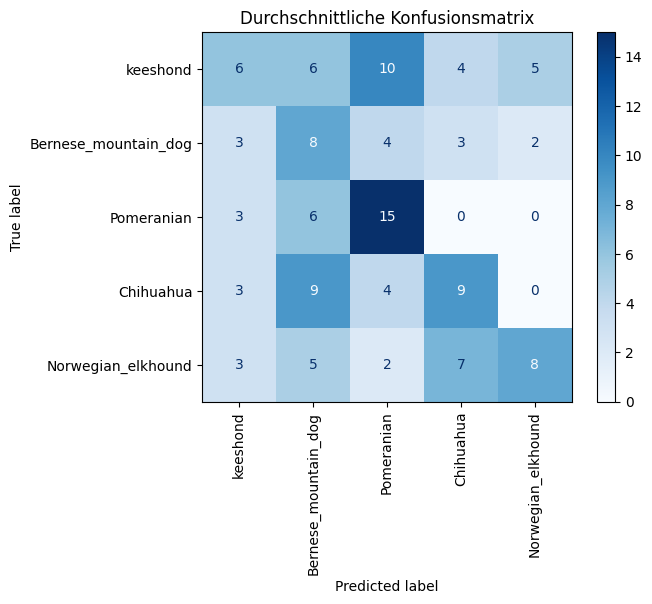

Test accuracy: 0.368


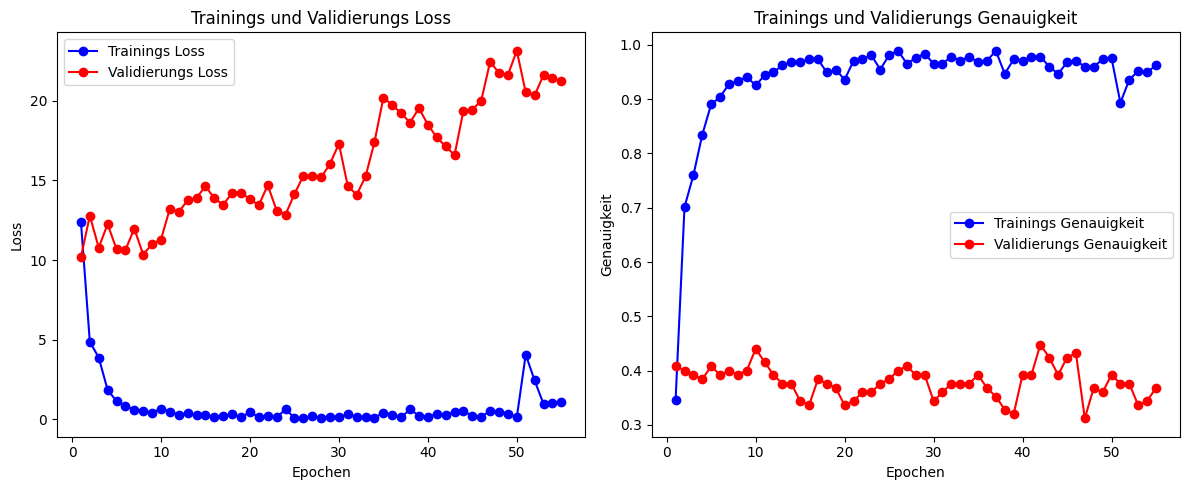

In [11]:
images, labels = generateDatasetArrays(train_dataset)
images_test, labels_test = generateDatasetArrays(test_dataset)

history = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=50,
    batch_size=Config.BATCH_SIZE,
    verbose=1 if Config.DEBUG else 0
)

# Feinabstimmung des gesamten Modells
for layer in model.layers:
    layer.trainable = True  # Alle Schichten freigeben

# Reduzierte Lernrate für Fine-Tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Finetuning des gesamten Modells")
history_finetune = model.fit(
    images, labels,
    validation_data=(images_test, labels_test),
    epochs=5,
    batch_size=32,
    verbose=1 if Config.DEBUG else 0
)

# Evaluation
y_pred = model.predict(images_test)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(getDognames(train_dataset).values())

print("Konfusionsmatrix:")
# Visualisierung der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_test, y_pred_classes), display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Durchschnittliche Konfusionsmatrix")
plt.show()

loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy: %.3f' % acc)


for key in history.history.keys():
    history.history[key].extend(history_finetune.history[key])

visualize_history(history.history)

model.save(os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME))

# Evaluation Transfer Learning (Aufgabe 6)

Trotz dessen hat das neue Modell mit den neuen Hunderassen eine schlechtere Genauigkeit (0,39(neues Modell) zu 0,58(altes Modell)).Dieser Unterschied kann auf die starken Unterschiede in den ausgewählten Hunderassen zurück geführt werden. Vermutlich schneided das Transfer Learning Modell schlechter ab, da die Feature Exraction auf die Hunde des ersten Modells angepasst ist.

Jedoch ist auch ein klarer Unterschied zwischen dem Deep Learning Model und dem Transfer Learning Modell zu erkennen. Das Deep Learning Modell kennt die Klassen Labels nicht und "rät" somit. Dadurch hat es einen langfristigen Erwartungswert von 0.2 (20%). In meinem Test sogar nur von 0.16 (16%), weil es nicht wirklich zufällig rät, sondern basierend auf der Eingabe denkt, es erkennt einen Hund. 

Test accuracy (Deep Learning): 0.160
Test accuracy (Transfer Learning): 0.368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


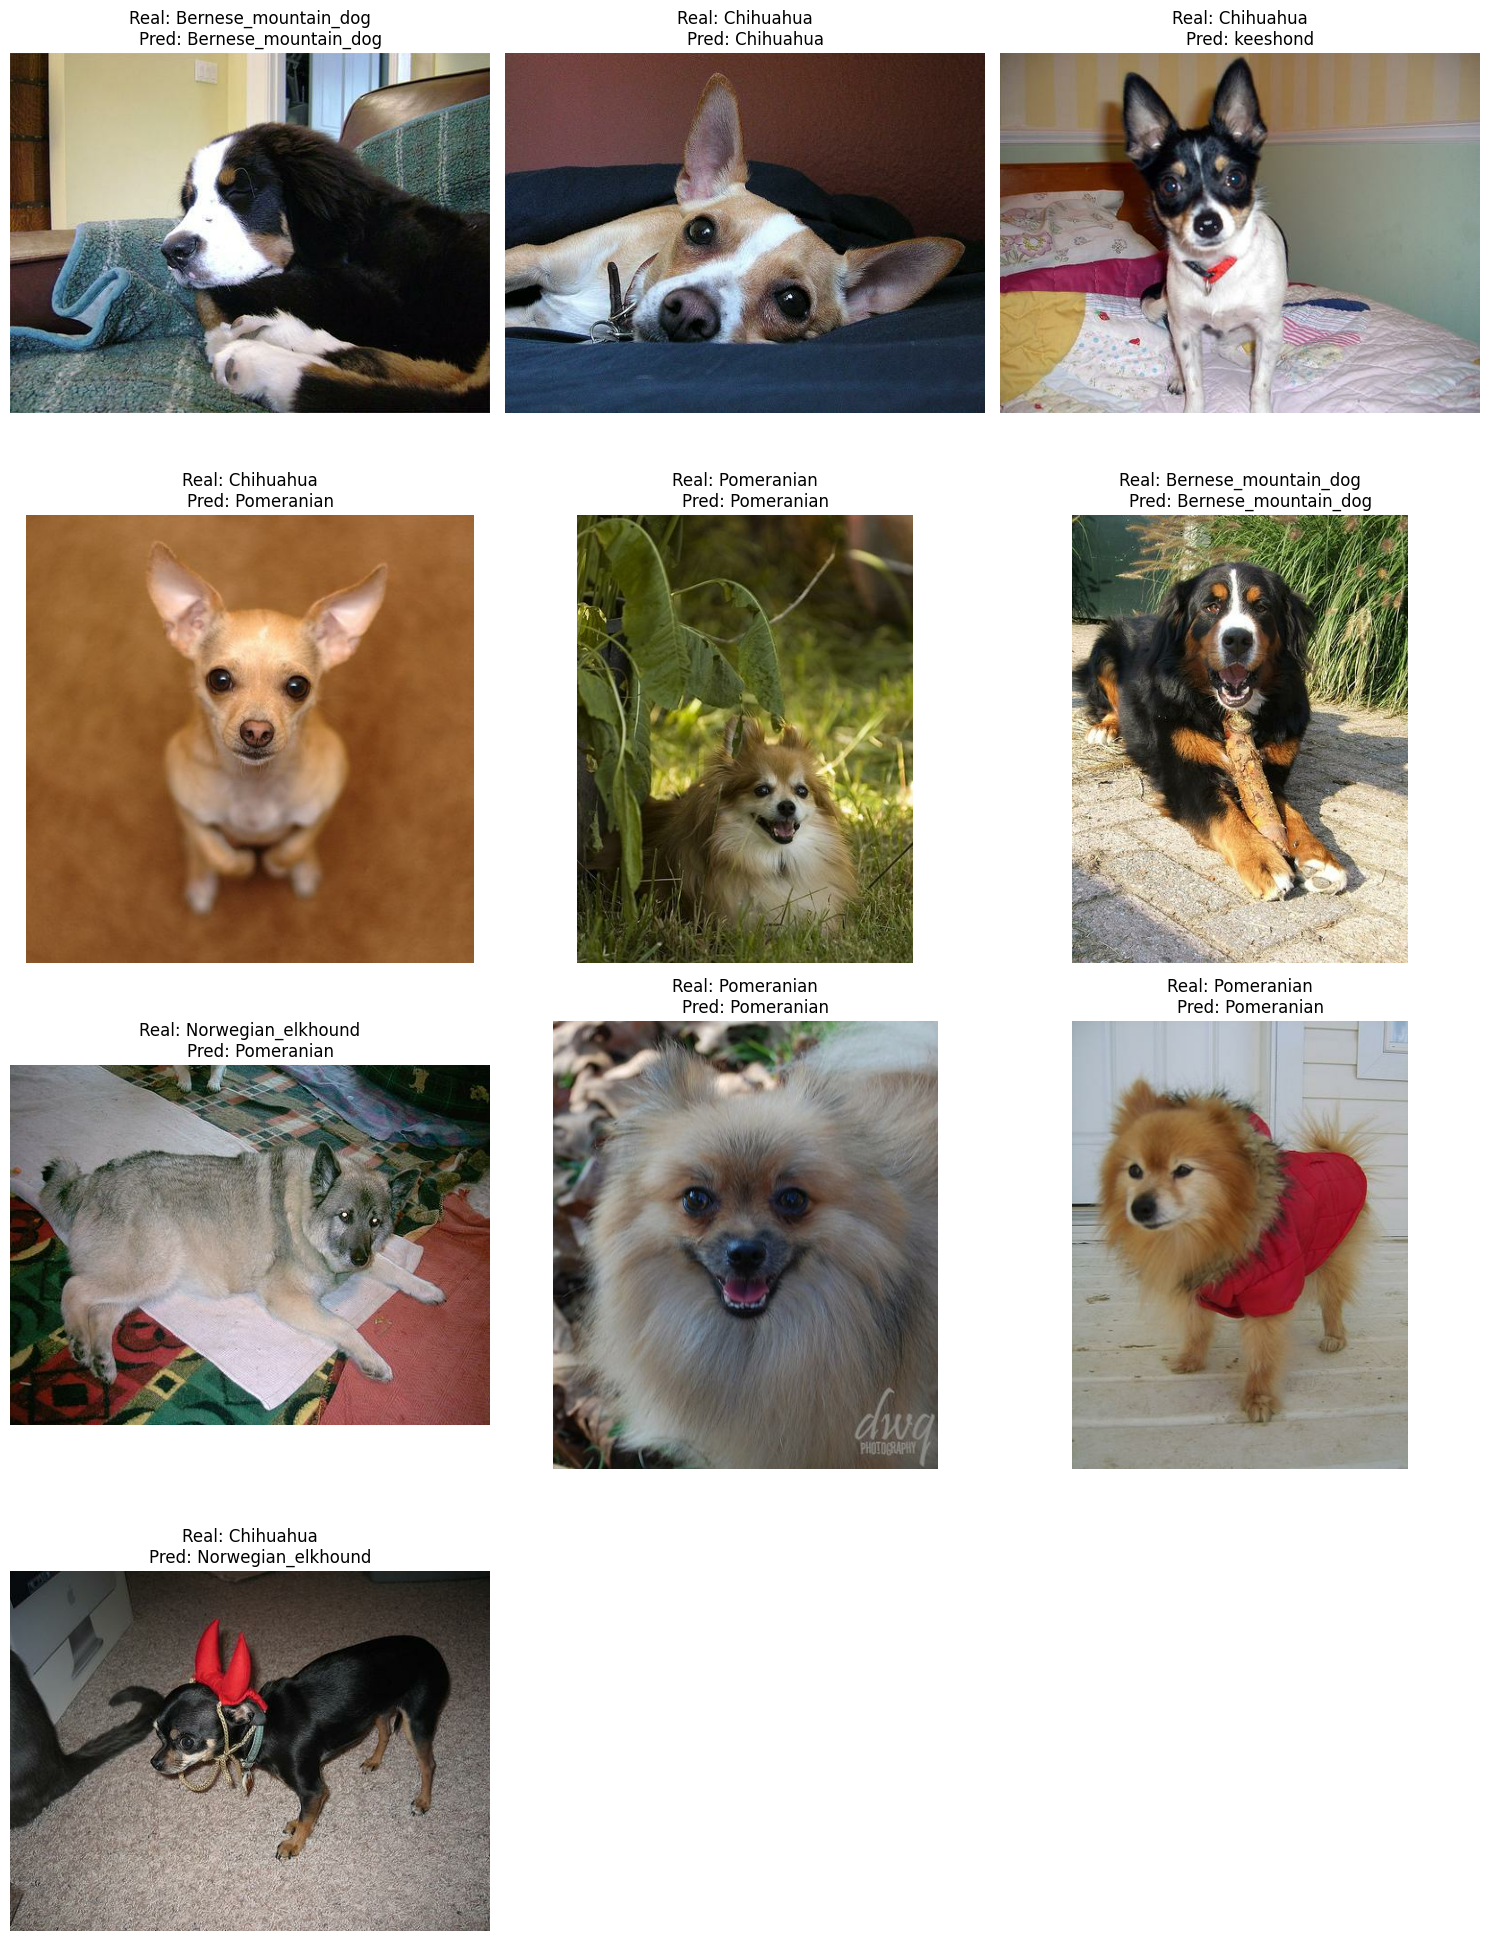

In [12]:
model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.MODEL_FILENAME))
loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy (Deep Learning): %.3f' % acc)

model = keras.models.load_model(os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME))
loss, acc = model.evaluate(images_test, labels_test, verbose=0)
print('Test accuracy (Transfer Learning): %.3f' % acc)

visualize_predictions(
    os.path.join(Config.MODEL_FOLDER, Config.TRANSFER_MODEL_FILENAME),
    test_dataset
)